In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import seaborn as sns

In [2]:
params = [16, 256, 65536]

In [3]:
# Load data from file "./lists/output-100-16-???.txt" the ??? are seeds.
# every file is a list of 2 lists: [rewards, best_arms, value of first arm, value of second arm, value of third arm, value of fourth arm, value of fifth arm]
# best_arms is a list of the best arm at each timestep in one run
# rewards is a list of the reward at each timestep in one run
# value of first arm is the true value of the first arm
# value of second arm is the true value of the second arm
# value of third arm is the true value of the third arm
# value of fourth arm is the true value of the fourth arm
# value of fifth arm is the true value of the fifth arm
# We need to collect the rewards and best_arms in every file and average them
# use the regex to find the files "./lists/output-???-???-???.txt", ??? are numbers, and load them

def load_data(param):
    files = glob.glob("./lists/output-100-" + str(param) + "-????.txt")
    data = [0] * len(files)
    for i, file in enumerate(files):
        with open(file, "r") as f:
            data[i] = [int(x) for x in json.load(f)[1]]
    return data

In [4]:
data_16 = np.array(load_data(16))
data_256 = np.array(load_data(256))
data_65536 = np.array(load_data(65536))
data_16.shape

(100, 100)

In [5]:
data_16[0]

array([48, 48, 48, 46, 48, 48, 48, 48, 46, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 46, 48, 48, 48, 48, 46, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 46, 48, 48, 48, 48, 46, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       46, 48, 48, 48, 48, 46, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 46,
       48, 48, 48, 48, 46, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 46, 48,
       48, 48, 48, 46, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 46])

In [6]:
average_16 = np.mean(data_16, axis=0)
average_256 = np.mean(data_256, axis=0)
average_65536 = np.mean(data_65536, axis=0)

In [7]:
# calculate the cumulative average
cumulative_average_16 = np.cumsum(average_16) / np.arange(1, len(average_16) + 1)
cumulative_average_256 = np.cumsum(average_256) / np.arange(1, len(average_256) + 1)
cumulative_average_65536 = np.cumsum(average_65536) / np.arange(1, len(average_65536) + 1)

In [8]:
# the real reward is - cumulative_average
cumulative_average_16 = - cumulative_average_16
cumulative_average_256 = - cumulative_average_256
cumulative_average_65536 = - cumulative_average_65536

In [9]:
class GridworldWithSpecificReversalEnv:
    def __init__(self):
        self.n_states = 4  # 4 states in total
        self.n_actions = 2  # 2 actions in total, 0 for left and 1 for right
        self.state = 0  # always start from the leftmost state

    def reset(self):
        self.state = 0  # reset to the leftmost state
        return self.state

    def step(self, action):
        # reverse the action if the current state is 1
        if self.state == 1:
            action = 1 - action  # reverse the action

        next_state = self.state
        if action == 1:  # move right
            if self.state < self.n_states - 1:
                next_state += 1
        elif action == 0:  # move left
            if self.state > 0:
                next_state -= 1

        # update the state
        self.state = next_state
        
        # change the reward
        if self.state == 3 and action == 1:
            reward = 0  # the reward is 0 when reaching the rightmost state by moving right
        else:
            reward = -1  # punish -1 for each step

        done = self.state == 3  # terminate if the agent reaches the rightmost state
        return self.state, reward, done

In [10]:
def relu(x):
    return np.maximum(0, x)

def notthatsoftmax(logits):
    # use ReLU to adjust the logits
    transformed = relu(logits - np.min(logits))+1  # add 1 to make sure all elements are positive
    return transformed / np.sum(transformed)  # normalize

In [11]:
class REINFORCE_ReLU:
    def __init__(self, env, alpha=0.01, gamma=0.9):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        # initialize the policy parameter, theta
        self.theta = np.zeros((env.n_states, env.n_actions))
        self.episode_rewards = []
        self.episode_theta = []

    def policy(self, state):
        """calculate the action probabilities of a state"""
        preferences = self.theta[state]
        action_probs = notthatsoftmax(preferences)  # use the custom softmax function
        return action_probs

    def choose_action(self, state):
        """select an action given the state"""
        action_probs = self.policy(state)
        action = np.random.choice(self.env.n_actions, p=action_probs)
        return action

    def update_policy(self, states, actions, rewards):
        """update the policy parameter using the REINFORCE algorithm"""
        T = len(rewards)
        for t in range(T):
            G_t = sum([rewards[t+i] for i in range(T-t)])  # calculate the return
            state = states[t]
            action = actions[t]
            probs = self.policy(state)
            d_policy = -probs.copy()
            d_policy[action] += 1
            self.theta[state] += self.alpha * d_policy * G_t  # update the policy parameter

    def update_policy_rollback(self, states, actions, rewards):
        """use a matrix to update the policy parameter"""
        T = len(rewards)
        # use a matrix to store the intermediate results
        theta_temp = np.zeros((self.env.n_states, self.env.n_actions))
        for t in range(T):
            theta_temp[states[t], actions[t]] += 1
            G_t = sum([rewards[t+i] for i in range(T-t)])  # calculate the cumulative return
        for s in range(self.env.n_states):
            for a in range(self.env.n_actions):
                self.theta[s, a] += self.alpha * theta_temp[s, a] * G_t # update the policy parameter

    def train(self, num_episodes):
        """train the agent for a number of episodes"""
        for episode in range(num_episodes):
            state = self.env.reset()
            states, actions, rewards = [], [], []

            while len(rewards)<=50:
                action = self.choose_action(state)
                next_state, reward, _ = self.env.step(action)
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                state = next_state

            self.update_policy(states, actions, rewards)
            self.episode_rewards.append(sum(rewards))
            self.episode_theta.append(self.theta.copy())
        
        return self.episode_rewards, self.episode_theta

In [ ]:
# eg: [1,2] + [3,4] = [4,6]

In [13]:
num_episodes = 100
rewards_relu_all = []
for i in range(20):
    # random seed
    np.random.seed(3571+i)
    # initialize the environment and the agent
    env = GridworldWithSpecificReversalEnv()
    agent_relu = REINFORCE_ReLU(env, alpha=0.01, gamma=0.99)
    rewards_relu, _ = agent_relu.train(num_episodes)
    # cumulate the rewards
    if len(rewards_relu_all) == 0:
        rewards_relu_all = rewards_relu
    else:
        rewards_relu_all = [rewards_relu_all[i] + rewards_relu[i] for i in range(num_episodes)]

cum_rewards_relu = np.cumsum(rewards_relu_all)
cum_rewards_relu = [cum_rewards_relu[i] / (i + 1) for i in range(num_episodes)]
cum_rewards_relu = np.array(cum_rewards_relu) / 20

In [14]:
sns.set_theme(style="white", palette=None, font_scale=2.2)

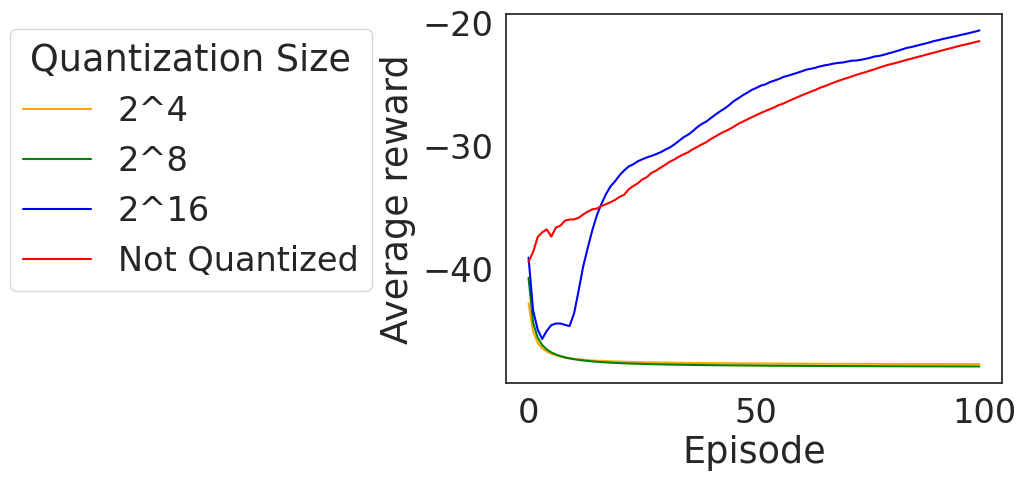

In [15]:
# plot the average rewards with legend on the left
sns.lineplot(cumulative_average_16, label="2^4", color="orange")
sns.lineplot(cumulative_average_256, label="2^8", color="green")
sns.lineplot(cumulative_average_65536, label="2^16", color="blue")
sns.lineplot(cum_rewards_relu, label="Not Quantized", color = "red")
plt.legend(title='Quantization Size', loc=(-1.0, 0.25))
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.savefig('fig_left.pdf', format='pdf', bbox_inches='tight')
plt.show()

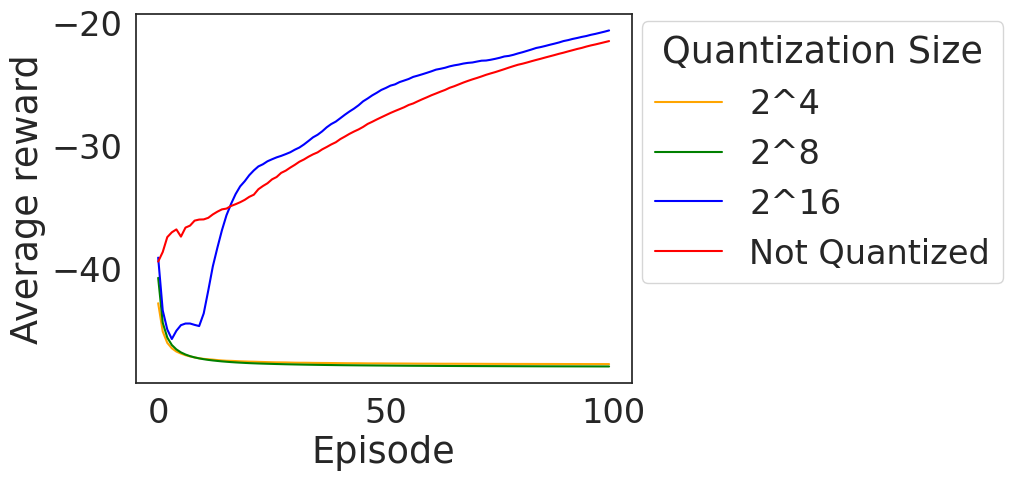

In [16]:
# plot the average rewards with legend on the right
sns.lineplot(cumulative_average_16, label="2^4", color="orange")
sns.lineplot(cumulative_average_256, label="2^8", color="green")
sns.lineplot(cumulative_average_65536, label="2^16", color="blue")
sns.lineplot(cum_rewards_relu, label="Not Quantized", color = "red")
plt.legend(title='Quantization Size', loc=(1.02, 0.27))
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.savefig('fig_right.pdf', format='pdf', bbox_inches='tight')
plt.show()

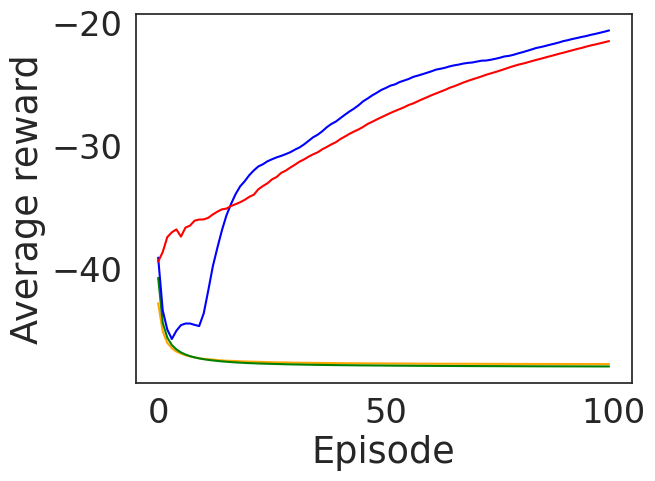

In [17]:
# plot the average rewards without legend
sns.lineplot(cumulative_average_16, color="orange")
sns.lineplot(cumulative_average_256, color="green")
sns.lineplot(cumulative_average_65536, color="blue")
sns.lineplot(cum_rewards_relu, color = "red")
# plt.legend(title='Quantization Size', loc=(-1.0, 0.2))
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.savefig('fig_non.pdf', format='pdf', bbox_inches='tight')
plt.show()